In [3]:
# import sys
# !{sys.executable} -m pip install --pre mesa
# !{sys.executable} -m pip install colorama
# !{sys.executable} -m pip install openpyxl
# !{sys.executable} -m pip install ema_workbench 

In [2]:
# import libraries
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.animation import FuncAnimation
import mesa
import sys
from mesa import Agent, Model
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
import numpy as np
import pandas as pd
import math
from IPython.display import HTML
from matplotlib import rc
from matplotlib.colors import ListedColormap
from colorama import Fore, Back, Style
from scipy.stats import linregress


This code runs with mesa version 3.00 or higher

In [3]:
# check mesa version
print("Mesa version: ", mesa.__version__)

Mesa version:  3.0.2


In [4]:
# Load the Excel file
#Floorplan_base_line.xlsx contains no signs; Floorplan_signs.xlsx contains signs throughout the floorplan and responds to intervention 1

file_path = 'Floorplan_base_line.xlsx'  # Replace with your file path
df = pd.read_excel(file_path, header=None)  # Load the data without assuming any headers

In [5]:
# Initialize lists for each category
self_obstacles = []
self_empty = []
self_exits = []
self_signs = []
self_low_obstacles = []


# Iterate through the DataFrame to find the coordinates for each category
for y in range(df.shape[0]):  # Iterate over rows (height)
    for x in range(df.shape[1]):  # Iterate over columns (width)
        value = df.iloc[y, x]  # Get the value at position (x, y)
        
        # Check the value and store the coordinates in the appropriate list
        if value == 1:
            self_obstacles.append((x, y))
        elif value == 3:
            self_exits.append((x, y))
        elif value == 4:
            self_signs.append((x, y))
        elif value == 5:
            self_low_obstacles.append((x, y))
        elif value == 0:
            self_empty.append((x, y))

# Example print statements to check the lists
print("Obstacles:", self_obstacles)
print("Exits:", self_exits)
print("Signs:", self_signs)
print("low obstacles:", self_low_obstacles)	
print("Floor surface:", len(self_empty) + len(self_signs), "m2")

Obstacles: [(0, 0), (1, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (10, 0), (11, 0), (12, 0), (13, 0), (14, 0), (15, 0), (16, 0), (17, 0), (18, 0), (19, 0), (20, 0), (21, 0), (22, 0), (23, 0), (24, 0), (25, 0), (26, 0), (27, 0), (28, 0), (29, 0), (30, 0), (31, 0), (32, 0), (33, 0), (0, 1), (4, 1), (15, 1), (19, 1), (23, 1), (33, 1), (0, 2), (14, 2), (15, 2), (19, 2), (23, 2), (0, 3), (4, 3), (14, 3), (15, 3), (19, 3), (23, 3), (24, 3), (27, 3), (28, 3), (29, 3), (30, 3), (31, 3), (32, 3), (33, 3), (0, 4), (4, 4), (15, 4), (23, 4), (33, 4), (0, 5), (4, 5), (15, 5), (16, 5), (17, 5), (21, 5), (22, 5), (33, 5), (0, 6), (4, 6), (15, 6), (33, 6), (0, 7), (4, 7), (15, 7), (33, 7), (0, 8), (4, 8), (15, 8), (33, 8), (0, 9), (4, 9), (33, 9), (0, 10), (4, 10), (33, 10), (0, 11), (4, 11), (15, 11), (33, 11), (0, 12), (4, 12), (15, 12), (33, 12), (0, 13), (4, 13), (15, 13), (23, 13), (33, 13), (0, 14), (4, 14), (15, 14), (23, 14), (33, 14), (0, 15), (4, 15), (15, 15), (23, 15), (33, 15), (0, 16),

In [6]:
# Function to calculate Euclidean distance (distance between two points)
def euclidean_distance(pos1, pos2):
    # Use the formula to calculate distance between two coordinates
    return math.sqrt((pos1[0] - pos2[0]) ** 2 + (pos1[1] - pos2[1]) ** 2)

# Base Model

In [7]:
###################
### AGENT CLASS ###
###################

class NavigationAgent(Agent):
    def __init__(self, model, vision=8, activated=True, toxicated=False):  # Default vision range of 8 cells
        super().__init__(model)  # MESA `Agent` class initialization
        self.found_exit = False  # Track if agent has reached the exit
        self.previous_pos = None  # Previous position of the agent
        self.vision = vision  # Vision range of the agent
        self.activated = activated  # Activation state of the agent
        self.toxicated = toxicated  # Toxicated state of the agent
        self.memory = set()  # Memory to keep track of seen signs

    # Function to get the agent's vision area, excluding cells blocked by obstacles
    def get_filtered_vision_area(self):
        vision_area = set()
        x, y = self.pos
        for dx in range(-self.vision, self.vision + 1):
            for dy in range(-self.vision, self.vision + 1):
                nx, ny = x + dx, y + dy
                if not (0 <= nx < self.model.grid.width and 0 <= ny < self.model.grid.height):
                    continue
                if not self.is_visible((nx, ny)):
                    continue
                vision_area.add((nx, ny))
        return vision_area

    # Helper function to check if a target cell is visible considering obstacles
    def is_visible(self, target):
        x1, y1 = self.pos
        x2, y2 = target
        dx, dy = abs(x2 - x1), abs(y2 - y1)
        sx, sy = (1 if x1 < x2 else -1), (1 if y1 < y2 else -1)
        err = dx - dy

        while (x1, y1) != (x2, y2):
            if (x1, y1) in self.model.obstacles:
                return False
            e2 = 2 * err
            if e2 > -dy:
                err -= dy
                x1 += sx
            if e2 < dx:
                err += dx
                y1 += sy
        return True

    # Function to move the agent randomly if no target is in sight
    def move_randomly(self):
        self.previous_pos = self.pos
        possible_steps = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
        valid_steps = [step for step in possible_steps if step not in self.model.obstacles and step not in self.model.low_obstacles and len(self.model.grid.get_cell_list_contents(step)) < 8]
        if valid_steps:
            random_step = self.random.choice(valid_steps)
            self.model.grid.move_agent(self, random_step)

    # Function to move the agent towards a target (exit or sign)
    def move_towards_target(self, target_locations):
        self.previous_pos = self.pos
        possible_steps = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
        min_distance = float('inf')
        best_step = None
        for step in possible_steps:
            if step not in self.model.obstacles and step not in self.model.low_obstacles and len(self.model.grid.get_cell_list_contents(step)) < 8:
                dist_to_closest_target = min(euclidean_distance(step, target_loc) for target_loc in target_locations)
                if dist_to_closest_target < min_distance:
                    min_distance = dist_to_closest_target
                    best_step = step
        if best_step:
            self.model.grid.move_agent(self, best_step)

    # Define the actions the agent will take in each step
    def step(self):
        if not self.activated:
            vision_area = self.get_filtered_vision_area()
            activated_neighbors = 0
            for neighbor_pos in vision_area:
                neighbor_agents = self.model.grid.get_cell_list_contents(neighbor_pos)
                for agent in neighbor_agents:
                    if isinstance(agent, NavigationAgent) and agent.activated:
                        activated_neighbors += 1
                        if (not self.toxicated and activated_neighbors >= 1) or (self.toxicated and activated_neighbors >= 3):
                            self.activated = True
                            break
                if self.activated:
                    break
            if not self.activated:
                return
        if self.pos in self.model.exit_locations:
            self.found_exit = True
            self.model.grid.remove_agent(self)
            self.remove()
            self.model.cumulative_exited += 1
        else:
            vision_area = self.get_filtered_vision_area()
            exits_in_vision = [exit_loc for exit_loc in self.model.exit_locations if exit_loc in vision_area]
            signs_in_vision = [sign_loc for sign_loc in vision_area if sign_loc in self.model.signs and sign_loc not in self.memory]
            if exits_in_vision:
                self.move_towards_target(exits_in_vision)
            elif signs_in_vision:
                self.move_towards_target(signs_in_vision)
                self.memory.update(signs_in_vision)
            else:
                self.move_randomly()

###################
### MODEL CLASS ###
###################

# Define the model class to handle the overall environment
class FloorPlanModel(Model):
    def __init__(self, width, height, num_agents, agent_vision):
        super().__init__()  # `Model` class initialization
        
        # Basic model settings
        self.num_agents = num_agents
        self.agent_vision = agent_vision
        self.grid = MultiGrid(width, height, False)  # MESA grid with dimensions; False means no wrapping
        self.exit_locations = self_exits  # Place exits

        # Define obstacles and signs in the grid
        self.obstacles = self_obstacles
        self.signs = self_signs 
        self.low_obstacles = self_low_obstacles
        
        # Initialize cumulative exited count
        self.cumulative_exited = 0

        # Initialize DataCollector (MESA tool for tracking metrics across steps)
        self.datacollector = DataCollector(
            model_reporters={
                "Active Agents": lambda m: len(m.agents),  # Count of agents still active
                "Exited Agents": lambda m: sum(1 for agent in m.agents if isinstance(agent, NavigationAgent) and agent.found_exit),
                "Cumulative Exited Agents": lambda m: m.cumulative_exited,  # Cumulative exited count
                "Density": lambda m: m.density(),  # Calculate density of agents in the grid
                "Percentage Exited": lambda m: m.percentage_exited(),  # Calculate percentage of agents that have exited
                "Agents per Cell": self.count_agents_per_cell,  # Counts agents in each cell
                "Agents in Exits": self.count_agents_in_exits,  # Counts agents in exit cells
                "Cumulative exited agents per exit": self.exit_count_per_exit  # Accumulates agents that have stepped on each exit cell over time
            },
            agent_reporters={
                "Found Exit": lambda a: a.found_exit if isinstance(a, NavigationAgent) else None,  # Reports exit status per agent
                "Toxicated": lambda a: a.toxicated if isinstance(a, NavigationAgent) else None  # Reports toxicated status per agent
            }
        )

        self.place_agents(agent_vision)  # Place agents on the grid
        self.datacollector.collect(self)  # Collect data at the start of the simulation


    # Function to randomly place agents in the grid
    def place_agents(self, agent_vision):
        num_activated_agents = int(self.num_agents * 0.40)  #  40% of the total agents are activated initially
        num_toxicated_agents = int(self.num_agents * 0.3)  #  30% of the total agents are toxicated
        for i in range(self.num_agents):
            activated = i < num_activated_agents  # Activate the first 30% of agents
            toxicated = i < num_toxicated_agents  # Toxicate the first 60% of agents
            vision = agent_vision if not toxicated else agent_vision // 2  # Set vision based on toxicated state
            agent = NavigationAgent(self, vision=vision, activated=activated, toxicated=toxicated)  # Create agent with initial vision range, activation state, and toxicated state
            placed = False  # Track if the agent is successfully placed
            while not placed:
                x = self.random.randrange(self.grid.width)
                y = self.random.randrange(self.grid.height)
                cell_contents = self.grid.get_cell_list_contents((x, y))

                # Only place agent if cell has no obstacles, low obstacles, and fewer than 8 agents
                if (x, y) not in self.obstacles and (x, y) not in self.low_obstacles and len(cell_contents) < 8:
                    self.grid.place_agent(agent, (x, y))  # MESA function to place agent in grid
                    placed = True  # Mark as placed

    # Function to count agents in each cell
    def count_agents_per_cell(self):
        agent_counts = {}  # Dictionary to store agent counts by cell position
        # MESA `coord_iter` function iterates over grid cells and their contents
        for cell in self.grid.coord_iter():
            cell_contents, (x, y) = cell  # Unpack cell contents and coordinates
            # Count NavigationAgents in each cell
            nav_agent_count = sum(1 for obj in cell_contents if isinstance(obj, NavigationAgent))
            if nav_agent_count > 0:
                agent_counts[(x, y)] = nav_agent_count
        return agent_counts
    
    # Function to count agents in exit cells
    def count_agents_in_exits(self):
        exit_agent_counts = {}  # Dictionary to store agent counts by exit cell position
        for exit_pos in self.exit_locations:
            cell_contents = self.grid.get_cell_list_contents(exit_pos)
            nav_agent_count = sum(1 for obj in cell_contents if isinstance(obj, NavigationAgent))
            if nav_agent_count > 0:
                exit_agent_counts[exit_pos] = nav_agent_count
        return exit_agent_counts
        
    # Function to accumulate agents that have stepped on each exit cell over time
    def exit_count_per_exit(self):
        if not hasattr(self, 'exit_agent_history'):
            self.exit_agent_history = {exit_pos: 0 for exit_pos in self.exit_locations}
            
        for exit_pos in self.exit_locations:
            cell_contents = self.grid.get_cell_list_contents(exit_pos)
            nav_agent_count = sum(1 for obj in cell_contents if isinstance(obj, NavigationAgent))
            self.exit_agent_history[exit_pos] += nav_agent_count
        return self.exit_agent_history

    # Function to calculate the density of agents in the grid
    def density(self):
        agent_counts = self.count_agents_per_cell()
        floor_surface = len(self_empty) + len(self_signs)
        total_agents = sum(agent_counts.values())
        density = total_agents / floor_surface
        return density
    
    # Function to calculate the percentage of agents that have exited
    def percentage_exited(self):
        return self.cumulative_exited / self.num_agents *100
    
    # Function to get the grid data for visualization
    def get_grid(self):
        # 0: empty, 1: obstacle, 2: agent, 3: exit, 4: sign, 5: low obstacle
        grid_data = np.zeros((self.grid.height, self.grid.width)) # Adjust order to (height, width)
        
        # Mark obstacles on the grid
        for x, y in self.obstacles:
            grid_data[y, x] = 1
        
        # Mark agents on the grid
        for agent in self.agents:
            if isinstance(agent, NavigationAgent):
                x, y = agent.pos
                grid_data[y, x] = 2
        
        # Mark signs and exit on the grid
        for x, y in self.signs:
            grid_data[y, x] = 4
        for x, y in self.exit_locations:
            grid_data[y, x] = 3  

        # Mark low obstacles on the grid
        for x, y in self.low_obstacles:
            grid_data[y, x] = 5

        return grid_data

    # Model step function to update the simulation
    def step(self):
        self.agents.do("step")  # MESA 3.0 function to execute the `step` function of each agent
        self.datacollector.collect(self)  # MESA DataCollector collects metrics at each step


In [8]:
#grid_data = model.get_grid()

In [12]:
# # BATCHRUNNER: Baseline (which is the same as scenario 2)


# # Define the parameters for the batch run 
# params = {
#     "width": 34,  # Model width
#     "height": 20,  # Model height
#     "num_agents": [300],  # Number of agents 
#     "agent_vision": [6]  # Agent vision 
# }

# # Execute the batch run
# results_base_line = mesa.batch_run(
#     FloorPlanModel,  # The model to run
#     parameters=params,  # Parameters to vary
#     iterations=20,  # Number of iterations per parameter combination
#     max_steps=150,  # Maximum steps per iteration
#     number_processes=1,  # number of cores to be used for parallel computing
#     data_collection_period=1,  # Collect data at every step
#     display_progress=True  # Display the progress of the batch run
# )

# # Convert the results to a DataFrame
# results_df = pd.DataFrame(results_base_line)

# # Save the results to an Excel file
# results_df.to_excel('results_base_line.xlsx', index=False)

  0%|          | 0/20 [00:00<?, ?it/s]

In [13]:
# # BATCHRUNNER: Intervention 2


# # Define the parameters for the batch run
# params = {
#     "width": 34,  # Model width
#     "height": 20,  # Model height
#     "num_agents": [300],  # Number of agents 
#     "agent_vision": [18]  # Agent vision 
# }

# # Execute the batch run
# results_intervention_2 = mesa.batch_run(
#     FloorPlanModel,  # The model to run
#     parameters=params,  # Parameters to vary
#     iterations=20,  # Number of iterations per parameter combination
#     max_steps=150,  # Maximum steps per iteration
#     number_processes=1,  # number of cores to be used for parallel computing
#     data_collection_period=1,  # Collect data at every step
#     display_progress=True  # Display the progress of the batch run
# )

# # Convert the results to a DataFrame
# results_df2 = pd.DataFrame(results_intervention_2)

# # Save the results to an Excel file
# results_df2.to_excel('results_intervention_2.xlsx', index=False)

  0%|          | 0/20 [00:00<?, ?it/s]

In [14]:
# # BATCHRUNNER: Intervention 1


# # PLEASE NOTE: CHANGE FLOORPLAN INTO FLOORPLAN WITH SIGNS
# # Define the parameters for the batch run
# params = {
#     "width": 34,  # Model width
#     "height": 20,  # Model height
#     "num_agents": [300],  # Number of agents 
#     "agent_vision": [6]  # Agent vision 
# }

# # Execute the batch run
# results_intervention_1 = mesa.batch_run(
#     FloorPlanModel,  # The model to run
#     parameters=params,  # Parameters to vary
#     iterations=20,  # Number of iterations per parameter combination
#     max_steps=150,  # Maximum steps per iteration
#     number_processes=1,  # number of cores to be used for parallel computing
#     data_collection_period=1,  # Collect data at every step
#     display_progress=True  # Display the progress of the batch run
# )

# # Convert the results to a DataFrame
# results_df1 = pd.DataFrame(results_intervention_1)

# # Save the results to an Excel file
# results_df1.to_excel('results_intervention_1.xlsx', index=False)

In [15]:
# #  BATCHRUNNER: Intervention 3


# # PLEASE NOTE: CHANGE FLOORPLAN INTO FLOORPLAN WITH SIGNS
# # Define the parameters for the batch run
# params = {
#     "width": 34,  # Model width
#     "height": 20,  # Model height
#     "num_agents": [300],  # Number of agents 
#     "agent_vision": [18]  # Agent vision
# }

# # Execute the batch run
# results_intervention_3 = mesa.batch_run(
#     FloorPlanModel,  # The model to run
#     parameters=params,  # Parameters to vary
#     iterations=20,  # Number of iterations per parameter combination
#     max_steps=150,  # Maximum steps per iteration
#     number_processes=1,  # number of cores to be used for parallel computing
#     data_collection_period=1,  # Collect data at every step
#     display_progress=True  # Display the progress of the batch run
# )

# # Convert the results to a DataFrame
# results_df3 = pd.DataFrame(results_intervention_3)

# # Save the results to an Excel file
# results_df3.to_excel('results_intervention_3.xlsx', index=False)

In [19]:
# # BATCHRUNNER: Scenario 1

# # PLEASE NOTE: CHANGE FLOORPLAN INTO FLOORPLAN WITH SIGNS
# # Define the parameters for the batch run
# params = {
#     "width": 34,  # Model width
#     "height": 20,  # Model height
#     "num_agents": [300],  # Number of agents 
#     "agent_vision": [6]  # Agent vision
# }

# # Execute the batch run
# results_scenario_1 = mesa.batch_run(
#     FloorPlanModel,  # The model to run
#     parameters=params,  # Parameters to vary
#     iterations=20,  # Number of iterations per parameter combination
#     max_steps=150,  # Maximum steps per iteration
#     number_processes=1,  # number of cores to be used for parallel computing
#     data_collection_period=1,  # Collect data at every step
#     display_progress=True  # Display the progress of the batch run
# )

# # Convert the results to a DataFrame
# results_dfs1 = pd.DataFrame(results_scenario_1)

# # Save the results to an Excel file
# results_dfs1.to_excel('results_scenario_1.xlsx', index=False)

  0%|          | 0/20 [00:00<?, ?it/s]

In [25]:
# # BATCHRUNNER: Scenario 3

# # PLEASE NOTE: CHANGE FLOORPLAN INTO FLOORPLAN WITH SIGNS
# # Define the parameters for the batch run
# params = {
#     "width": 34,  # Model width
#     "height": 20,  # Model height
#     "num_agents": [300],  # Number of agents 
#     "agent_vision": [6]  # Agent vision
# }

# # Execute the batch run
# results_scenario_3 = mesa.batch_run(
#     FloorPlanModel,  # The model to run
#     parameters=params,  # Parameters to vary
#     iterations=20,  # Number of iterations per parameter combination
#     max_steps=150,  # Maximum steps per iteration
#     number_processes=1,  # number of cores to be used for parallel computing
#     data_collection_period=1,  # Collect data at every step
#     display_progress=True  # Display the progress of the batch run
# )

# # Convert the results to a DataFrame
# results_dfs3 = pd.DataFrame(results_scenario_3)

# # Save the results to an Excel file
# results_dfs3.to_excel('results_scenario_3.xlsx', index=False)

  0%|          | 0/20 [00:00<?, ?it/s]

Average Density Values (scenario 1): [np.float64(0.643804347826087), np.float64(0.6291304347826087), np.float64(0.6080434782608695), np.float64(0.5835869565217392), np.float64(0.5563043478260871), np.float64(0.5305434782608697), np.float64(0.5041304347826087), np.float64(0.4958695652173913), np.float64(0.4909782608695652), np.float64(0.486304347826087), np.float64(0.4821739130434783), np.float64(0.4781521739130435), np.float64(0.4746739130434783), np.float64(0.4715217391304348), np.float64(0.46923913043478277), np.float64(0.4663043478260871), np.float64(0.4626086956521739), np.float64(0.45956521739130435), np.float64(0.4575), np.float64(0.4552173913043478), np.float64(0.4533695652173912), np.float64(0.45163043478260867), np.float64(0.44869565217391294), np.float64(0.4464130434782609), np.float64(0.44402173913043486), np.float64(0.44217391304347836), np.float64(0.43978260869565233), np.float64(0.4376086956521739), np.float64(0.4358695652173914), np.float64(0.43369565217391315), np.float

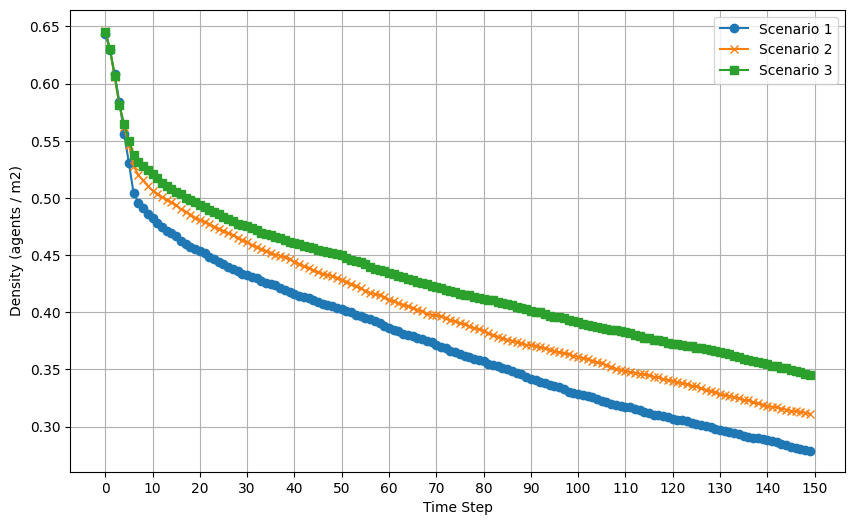

In [50]:
# Scenario RESULTS: DENSITY


# Read the Excel file
file_path_1 = 'results_scenario_1.xlsx'
file_path_3 = 'results_scenario_3.xlsx'
file_path_bl = 'results_base_line.xlsx'


df = pd.read_excel(file_path_3)

# Initialize a list to store the lists of density values for each iteration
density_lists_3 = []
# Group the DataFrame by 'Iteration'
grouped = df.groupby('iteration')

# Iterate through each group (iteration)
for iteration, group in grouped:
    # Initialize a list to store density values for the current iteration
    density_values = []
    
    # Iterate through each step in the current iteration
    for step in range(1, 151):  # Assuming steps are numbered from 1 to 150
        # Get the first row for the current step
        step_group = group[group['Step'] == step]
        if not step_group.empty:
            density_value = step_group.iloc[0]['Density']
            density_values.append(density_value)
    density_lists_3.append(density_values) # Append the list of density values for the current iteration to the main list

average_density_values_3 = [sum(density_values[step] for density_values in density_lists_3) / len(density_lists_3) for step in range(150)]
# Repeat the process for scenario 1 and scenario 2

# Scenario 1
df_scenario_1 = pd.read_excel(file_path_1)
density_lists_1 = []
grouped_1 = df_scenario_1.groupby('iteration')
for iteration, group in grouped_1:
    density_values = []
    for step in range(1, 151):
        step_group = group[group['Step'] == step]
        if not step_group.empty:
            density_value = step_group.iloc[0]['Density']
            density_values.append(density_value)
    density_lists_1.append(density_values)
average_density_values_1 = [sum(density_values[step] for density_values in density_lists_1) / len(density_lists_1) for step in range(150)]

# Scenario 2, please note that scenario 2 and baseline are the same
df_scenario_2 = pd.read_excel(file_path_bl)
density_lists_2 = []
grouped_2 = df_scenario_2.groupby('iteration')
for iteration, group in grouped_2:
    density_values = []
    for step in range(1, 151):
        step_group = group[group['Step'] == step]
        if not step_group.empty:
            density_value = step_group.iloc[0]['Density']
            density_values.append(density_value)
    density_lists_2.append(density_values)
average_density_values_2 = [sum(density_values[step] for density_values in density_lists_2) / len(density_lists_2) for step in range(150)]

# Print the average density values for all scenarios
print("Average Density Values (scenario 1):", average_density_values_1)
print("Average Density Values (scenario 2):", average_density_values_2)
print("Average Density Values (scenario 3):", average_density_values_3)

# Plot the average density values for all scenarios
plt.figure(figsize=(10, 6))
plt.plot(range(0, 150), average_density_values_1, label='Scenario 1', marker='o')
plt.plot(range(0, 150), average_density_values_2, label='Scenario 2', marker='x')
plt.plot(range(0, 150), average_density_values_3, label='Scenario 3', marker='s')
plt.xlabel('Time Step')
plt.ylabel('Density (agents / m2)')
plt.legend()
plt.xticks(np.arange(0, 151, 10))  # Set x-axis ticks from 10 to 100 in steps of 10
plt.savefig('results_density_scenarios.png')
plt.grid(True)
plt.show()

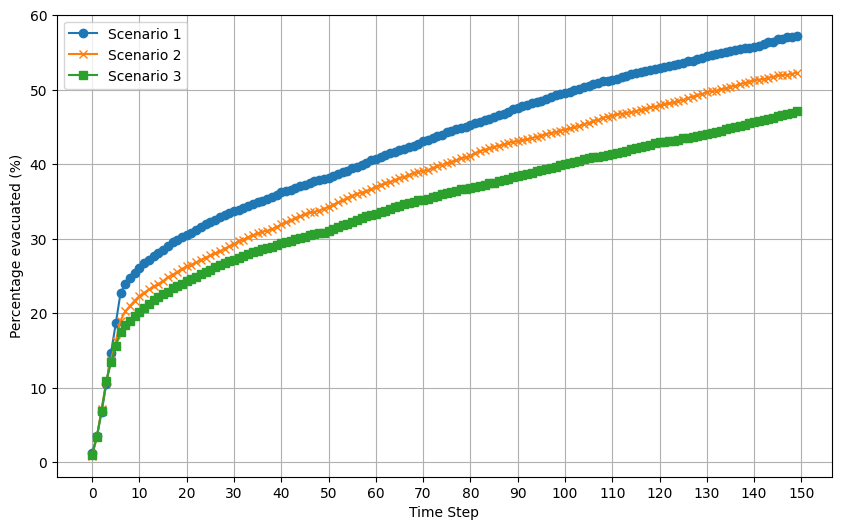

In [47]:
#Scenario RESULTS: Evacuated Agents


# Read the Excel file
file_path_1 = 'results_scenario_1.xlsx'
file_path_3 = 'results_scenario_3.xlsx'
file_path_bl = 'results_base_line.xlsx'

df = pd.read_excel(file_path_3)
percentage_exited_lists_3 = []
grouped = df.groupby('iteration')
for iteration, group in grouped:
    percentage_exited_values = []
    for step in range(1, 151):
        step_group = group[group['Step'] == step]
        if not step_group.empty:
            percentage_exited_value = step_group.iloc[0]['Percentage Exited']
            percentage_exited_values.append(percentage_exited_value)
    percentage_exited_lists_3.append(percentage_exited_values)
average_percentage_exited_values_3 = [sum(percentage_exited_values[step] for percentage_exited_values in percentage_exited_lists_3) / len(percentage_exited_lists_3) for step in range(150)]

# Scenario 1
df_scenario_1 = pd.read_excel(file_path_1)
percentage_exited_lists_1 = []
grouped_1 = df_scenario_1.groupby('iteration')
for iteration, group in grouped_1:
    percentage_exited_values = []
    for step in range(1, 151):
        step_group = group[group['Step'] == step]
        if not step_group.empty:
            percentage_exited_value = step_group.iloc[0]['Percentage Exited']
            percentage_exited_values.append(percentage_exited_value)
    percentage_exited_lists_1.append(percentage_exited_values)
average_percentage_exited_values_1 = [sum(percentage_exited_values[step] for percentage_exited_values in percentage_exited_lists_1) / len(percentage_exited_lists_1) for step in range(150)]

# scenario 2, please note that scenario 2 and the baseline are the same
df_baseline = pd.read_excel(file_path_bl)
percentage_exited_lists_bl = []
grouped_bl = df_baseline.groupby('iteration')
for iteration, group in grouped_bl:
    percentage_exited_values = []
    for step in range(1, 151):
        step_group = group[group['Step'] == step]
        if not step_group.empty:
            percentage_exited_value = step_group.iloc[0]['Percentage Exited']
            percentage_exited_values.append(percentage_exited_value)
    percentage_exited_lists_bl.append(percentage_exited_values)
average_percentage_exited_values_bl = [sum(percentage_exited_values[step] for percentage_exited_values in percentage_exited_lists_bl) / len(percentage_exited_lists_bl) for step in range(150)]

# Print the average percentage exited values for all scenarios
print("Average Percentage Exited Values (scenario 1):", average_percentage_exited_values_1)
print("Average Percentage Exited Values (baseline):", average_percentage_exited_values_bl)
print("Average Percentage Exited Values (scenario 3):", average_percentage_exited_values_3)

plt.figure(figsize=(10, 6))
plt.plot(range(0, 150), average_percentage_exited_values_1, label='Scenario 1', marker='o')
plt.plot(range(0, 150), average_percentage_exited_values_bl, label='Scenario 2', marker='x')
plt.plot(range(0, 150), average_percentage_exited_values_3, label='Scenario 3', marker='s')
plt.xlabel('Time Step')
plt.ylabel('Percentage Evacuated (%)')
plt.legend()
plt.xticks(np.arange(0, 151, 10))  # Set x-axis ticks from 0 to 150 in steps of 10
plt.savefig('results_percentage_evacuated_scenarios.png')
plt.grid(True)
plt.show()

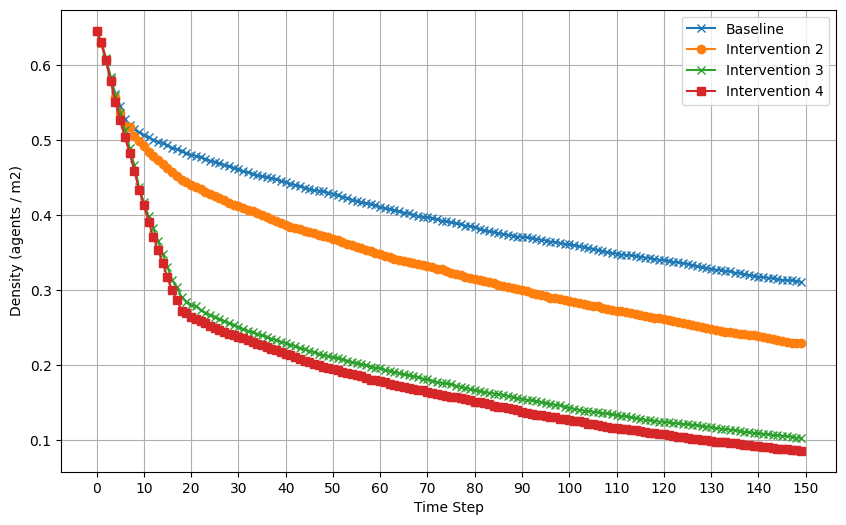

In [48]:
# Intervention RESULTS: DENSITY


# Read the Excel file
file_path_baseline = 'results_base_line.xlsx'
file_path_intervention_1 = 'results_intervention_1.xlsx'
file_path_intervention_2 = 'results_intervention_2.xlsx'
file_path_intervention_3 = 'results_intervention_3.xlsx'

# Baseline
df_baseline = pd.read_excel(file_path_baseline)
density_lists_baseline = []
grouped_baseline = df_baseline.groupby('iteration')
for iteration, group in grouped_baseline:
    density_values = []
    for step in range(1, 151):
        step_group = group[group['Step'] == step]
        if not step_group.empty:
            density_value = step_group.iloc[0]['Density']
            density_values.append(density_value)
    density_lists_baseline.append(density_values)
average_density_values_baseline = [sum(density_values[step] for density_values in density_lists_baseline) / len(density_lists_baseline) for step in range(150)]


# Intervention 1
df_intervention_1 = pd.read_excel(file_path_intervention_1)
density_lists_intervention_1 = []
grouped_intervention_1 = df_intervention_1.groupby('iteration')
for iteration, group in grouped_intervention_1:
    density_values = []
    for step in range(1, 151):
        step_group = group[group['Step'] == step]
        if not step_group.empty:
            density_value = step_group.iloc[0]['Density']
            density_values.append(density_value)
    density_lists_intervention_1.append(density_values)
average_density_values_intervention_1 = [sum(density_values[step] for density_values in density_lists_intervention_1) / len(density_lists_intervention_1) for step in range(150)]


# Intervention 2
df_intervention_2 = pd.read_excel(file_path_intervention_2)
density_lists_intervention_2 = []
grouped_intervention_2 = df_intervention_2.groupby('iteration')
for iteration, group in grouped_intervention_2:
    density_values = []
    for step in range(1, 151):
        step_group = group[group['Step'] == step]
        if not step_group.empty:
            density_value = step_group.iloc[0]['Density']
            density_values.append(density_value)
    density_lists_intervention_2.append(density_values)
average_density_values_intervention_2 = [sum(density_values[step] for density_values in density_lists_intervention_2) / len(density_lists_intervention_2) for step in range(150)]


# Intervention 3
df_intervention_3 = pd.read_excel(file_path_intervention_3)
density_lists_intervention_3 = []
grouped_intervention_3 = df_intervention_3.groupby('iteration')
for iteration, group in grouped_intervention_3:
    density_values = []
    for step in range(1, 151):
        step_group = group[group['Step'] == step]
        if not step_group.empty:
            density_value = step_group.iloc[0]['Density']
            density_values.append(density_value)
    density_lists_intervention_3.append(density_values)
average_density_values_intervention_3 = [sum(density_values[step] for density_values in density_lists_intervention_3) / len(density_lists_intervention_3) for step in range(150)]


# Print the average density values for all interventions
print("Average Density Values (baseline):", average_density_values_baseline)
print("Average Density Values (intervention 1):", average_density_values_intervention_1)
print("Average Density Values (intervention 2):", average_density_values_intervention_2)
print("Average Density Values (intervention 3):", average_density_values_intervention_3)

# Plot the average density values for all interventions
plt.figure(figsize=(10, 6))
plt.plot(range(0, 150), average_density_values_baseline, label='Baseline', marker='x')
plt.plot(range(0, 150), average_density_values_intervention_1, label='Intervention 2', marker='o')
plt.plot(range(0, 150), average_density_values_intervention_2, label='Intervention 3', marker='x')
plt.plot(range(0, 150), average_density_values_intervention_3, label='Intervention 4', marker='s')
plt.xlabel('Time Step')
plt.ylabel('Density (agents / m2)')
plt.legend()
plt.xticks(np.arange(0, 151, 10))  # Set x-axis ticks from 10 to 100 in steps of 10
plt.savefig('results_density_interventions.png')
plt.grid(True)
plt.show()


Average Percentage Exited Values (baseline): [np.float64(0.8999999999999998), np.float64(3.3999999999999995), np.float64(7.166666666666667), np.float64(10.833333333333334), np.float64(13.75), np.float64(16.249999999999996), np.float64(19.01666666666667), np.float64(20.266666666666673), np.float64(20.983333333333338), np.float64(21.699999999999996), np.float64(22.333333333333332), np.float64(22.749999999999996), np.float64(23.2), np.float64(23.6), np.float64(23.916666666666664), np.float64(24.316666666666666), np.float64(24.85), np.float64(25.149999999999995), np.float64(25.55), np.float64(25.96666666666666), np.float64(26.283333333333324), np.float64(26.51666666666667), np.float64(26.816666666666663), np.float64(27.166666666666668), np.float64(27.46666666666667), np.float64(27.76666666666667), np.float64(28.03333333333334), np.float64(28.316666666666663), np.float64(28.666666666666668), np.float64(28.98333333333333), np.float64(29.25), np.float64(29.7), np.float64(29.900000000000006), 

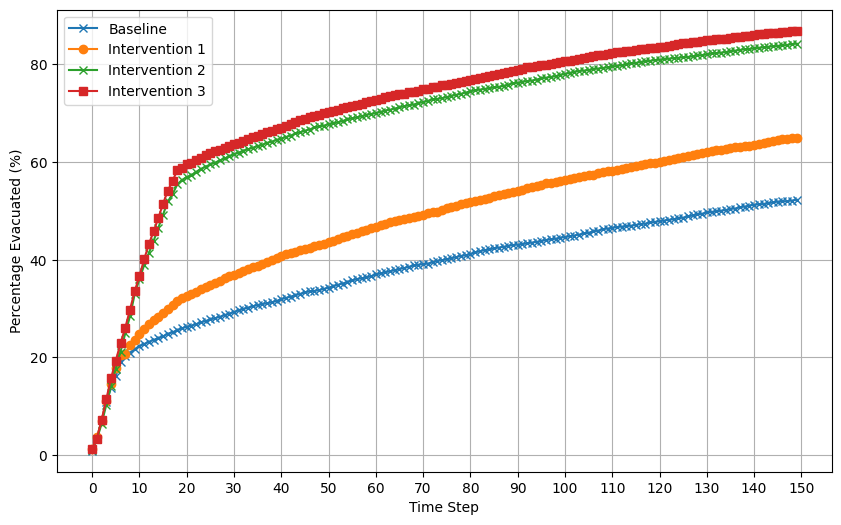

In [46]:
# Intervention RESULTS: Percentage Evacuated


# Read the Excel file
file_path_baseline = 'results_base_line.xlsx'
file_path_intervention_1 = 'results_intervention_1.xlsx'
file_path_intervention_2 = 'results_intervention_2.xlsx'
file_path_intervention_3 = 'results_intervention_3.xlsx'

# Baseline
df_baseline = pd.read_excel(file_path_baseline)
percentage_exited_lists_baseline = []
grouped_baseline = df_baseline.groupby('iteration')
for iteration, group in grouped_baseline:
    percentage_exited_values = []
    for step in range(1, 151):
        step_group = group[group['Step'] == step]
        if not step_group.empty:
            percentage_exited_value = step_group.iloc[0]['Percentage Exited']
            percentage_exited_values.append(percentage_exited_value)
    percentage_exited_lists_baseline.append(percentage_exited_values)
average_percentage_exited_values_baseline = [sum(percentage_exited_values[step] for percentage_exited_values in percentage_exited_lists_baseline) / len(percentage_exited_lists_baseline) for step in range(150)]

# Intervention 1
df_intervention_1 = pd.read_excel(file_path_intervention_1)
percentage_exited_lists_intervention_1 = []
grouped_intervention_1 = df_intervention_1.groupby('iteration')
for iteration, group in grouped_intervention_1:
    percentage_exited_values = []
    for step in range(1, 151):
        step_group = group[group['Step'] == step]
        if not step_group.empty:
            percentage_exited_value = step_group.iloc[0]['Percentage Exited']
            percentage_exited_values.append(percentage_exited_value)
    percentage_exited_lists_intervention_1.append(percentage_exited_values)
average_percentage_exited_values_intervention_1 = [sum(percentage_exited_values[step] for percentage_exited_values in percentage_exited_lists_intervention_1) / len(percentage_exited_lists_intervention_1) for step in range(150)]

# Intervention 2
df_intervention_2 = pd.read_excel(file_path_intervention_2)
percentage_exited_lists_intervention_2 = []
grouped_intervention_2 = df_intervention_2.groupby('iteration')
for iteration, group in grouped_intervention_2:
    percentage_exited_values = []
    for step in range(1, 151):
        step_group = group[group['Step'] == step]
        if not step_group.empty:
            percentage_exited_value = step_group.iloc[0]['Percentage Exited']
            percentage_exited_values.append(percentage_exited_value)
    percentage_exited_lists_intervention_2.append(percentage_exited_values)
average_percentage_exited_values_intervention_2 = [sum(percentage_exited_values[step] for percentage_exited_values in percentage_exited_lists_intervention_2) / len(percentage_exited_lists_intervention_2) for step in range(150)]

# Intervention 3
df_intervention_3 = pd.read_excel(file_path_intervention_3)
percentage_exited_lists_intervention_3 = []
grouped_intervention_3 = df_intervention_3.groupby('iteration')
for iteration, group in grouped_intervention_3:
    percentage_exited_values = []
    for step in range(1, 151):
        step_group = group[group['Step'] == step]
        if not step_group.empty:
            percentage_exited_value = step_group.iloc[0]['Percentage Exited']
            percentage_exited_values.append(percentage_exited_value)
    percentage_exited_lists_intervention_3.append(percentage_exited_values)
average_percentage_exited_values_intervention_3 = [sum(percentage_exited_values[step] for percentage_exited_values in percentage_exited_lists_intervention_3) / len(percentage_exited_lists_intervention_3) for step in range(150)]

# Print the average percentage exited values for all interventions
print("Average Percentage Exited Values (baseline):", average_percentage_exited_values_baseline)
print("Average Percentage Exited Values (intervention 1):", average_percentage_exited_values_intervention_1)
print("Average Percentage Exited Values (intervention 2):", average_percentage_exited_values_intervention_2)
print("Average Percentage Exited Values (intervention 3):", average_percentage_exited_values_intervention_3)

# Plot the average percentage exited values for all interventions
plt.figure(figsize=(10, 6))
plt.plot(range(0, 150), average_percentage_exited_values_baseline, label='Baseline', marker='x')
plt.plot(range(0, 150), average_percentage_exited_values_intervention_1, label='Intervention 1', marker='o')
plt.plot(range(0, 150), average_percentage_exited_values_intervention_2, label='Intervention 2', marker='x')
plt.plot(range(0, 150), average_percentage_exited_values_intervention_3, label='Intervention 3', marker='s')
plt.xlabel('Time Step')
plt.ylabel('Percentage Evacuated (%)')
plt.legend()
plt.xticks(np.arange(0, 151, 10))  # Set x-axis ticks from 10 to 100 in steps of 10
plt.savefig('results_percentage_evacuated_interventions.png')
plt.grid(True)
plt.show()


Relative Intoxicated Agents (baseline): [np.float64(0.6333333333333333), np.float64(0.6), np.float64(0.5222222222222223), np.float64(0.5555555555555556), np.float64(0.5666666666666667), np.float64(0.6), np.float64(0.5777777777777777), np.float64(0.4666666666666667), np.float64(0.6), np.float64(0.6444444444444445), np.float64(0.6555555555555556), np.float64(0.5777777777777777), np.float64(0.6666666666666666), np.float64(0.6444444444444445), np.float64(0.6333333333333333), np.float64(0.5666666666666667), np.float64(0.5444444444444444), np.float64(0.5333333333333333), np.float64(0.6555555555555556), np.float64(0.7)]
Relative Non-Intoxicated Agents (baseline): [np.float64(0.3952380952380952), np.float64(0.44761904761904764), np.float64(0.43333333333333335), np.float64(0.4095238095238095), np.float64(0.43333333333333335), np.float64(0.3761904761904762), np.float64(0.4142857142857143), np.float64(0.46190476190476193), np.float64(0.43333333333333335), np.float64(0.4523809523809524), np.float6

C:\Users\Isa\AppData\Local\Temp\ipykernel_20400\1974726963.py:125: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, patch_artist=True, labels=labels)


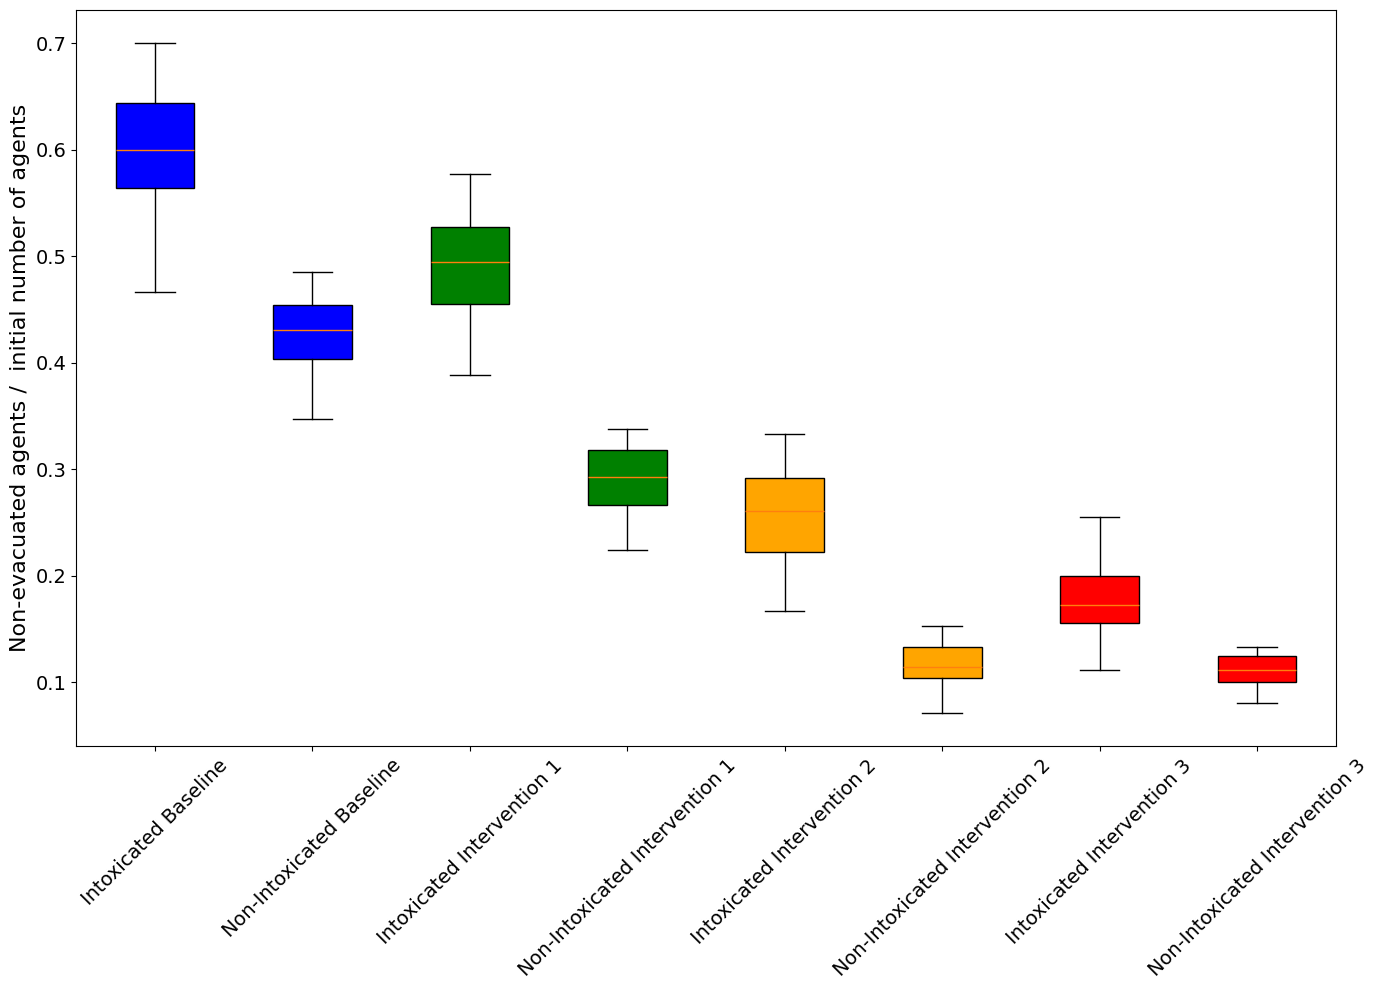

In [16]:
# Intervention RESULTS: intoxicated vs non-intoxicated agents at step 150.

# Read the Excel file
file_path_baseline = 'results_base_line.xlsx'
file_path_intervention_1 = 'results_intervention_1.xlsx'
file_path_intervention_2 = 'results_intervention_2.xlsx'
file_path_intervention_3 = 'results_intervention_3.xlsx'


Create lists to store the number of intoxicated and non-intoxicated agents for each intervention
intoxicated_baseline = []
non_intoxicated_baseline = []
intoxicated_intervention_1 = []
non_intoxicated_intervention_1 = []
intoxicated_intervention_2 = []
non_intoxicated_intervention_2 = []
intoxicated_intervention_3 = []
non_intoxicated_intervention_3 = []

initial_non_intoxicated = 0.7 * 300
initial_intoxicated = 0.3 * 300

# Function to calculate intoxicated and non-intoxicated agents for each iteration
def calculate_intoxicated_non_intoxicated(file_path):
    df = pd.read_excel(file_path)
    intoxicated_counts = []
    non_intoxicated_counts = []
    grouped = df.groupby('iteration')
    for iteration, group in grouped:
        step_group = group[group['Step'] == 150]
        if not step_group.empty:
            intoxicated_count = step_group['Toxicated'].sum()
            non_intoxicated_count = len(step_group) - intoxicated_count
            intoxicated_counts.append(intoxicated_count / initial_intoxicated)
            non_intoxicated_counts.append(non_intoxicated_count / initial_non_intoxicated)
    return intoxicated_counts, non_intoxicated_counts

# Calculate for baseline
intoxicated_baseline, non_intoxicated_baseline = calculate_intoxicated_non_intoxicated(file_path_baseline)

# Calculate for intervention 1
intoxicated_intervention_1, non_intoxicated_intervention_1 = calculate_intoxicated_non_intoxicated(file_path_intervention_1)

# Calculate for intervention 2
intoxicated_intervention_2, non_intoxicated_intervention_2 = calculate_intoxicated_non_intoxicated(file_path_intervention_2)

# Calculate for intervention 3
intoxicated_intervention_3, non_intoxicated_intervention_3 = calculate_intoxicated_non_intoxicated(file_path_intervention_3)


# Print the results
print("Relative Intoxicated Agents (baseline):", intoxicated_baseline)
print("Relative Non-Intoxicated Agents (baseline):", non_intoxicated_baseline)
print("Relative Intoxicated Agents (intervention 1):", intoxicated_intervention_1)
print("Relative Non-Intoxicated Agents (intervention 1):", non_intoxicated_intervention_1)
print("Relative Intoxicated Agents (intervention 2):", intoxicated_intervention_2)
print("Relative Non-Intoxicated Agents (intervention 2):", non_intoxicated_intervention_2)
print("Relative Intoxicated Agents (intervention 3):", intoxicated_intervention_3)
print("Relative Non-Intoxicated Agents (intervention 3):", non_intoxicated_intervention_3)


# Combine all data into a single list for plotting
data_to_plot = [
    intoxicated_baseline, non_intoxicated_baseline,
    intoxicated_intervention_1, non_intoxicated_intervention_1,
    intoxicated_intervention_2, non_intoxicated_intervention_2,
    intoxicated_intervention_3, non_intoxicated_intervention_3
]

# Labels for the boxplots
labels = [
    'Intoxicated Baseline', 'Non-Intoxicated Baseline',
    'Intoxicated Intervention 1', 'Non-Intoxicated Intervention 1',
    'Intoxicated Intervention 2', 'Non-Intoxicated Intervention 2',
    'Intoxicated Intervention 3', 'Non-Intoxicated Intervention 3'
]

# Colors for the boxplots
colors = ['blue', 'blue', 'green', 'green', 'orange', 'orange', 'red', 'red']

# Plot the boxplots for intoxicated and non-intoxicated agents for each intervention
plt.figure(figsize=(14, 10))

box = plt.boxplot(data_to_plot, patch_artist=True, labels=labels)

# Set colors for each box
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

plt.ylabel('Non-evacuated agents /  initial number of agents', fontsize=16)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig('results_intoxicated_non_intoxicated_combined_boxplots.png')
plt.show()


In [ ]:
# # SENSITIVITY ANALYSIS analysis for a) agent vision range and b) number of agents
# # Uncomommment to run


# # a) Sensitivity analysis for agent vision range
# visions = range(2, 22, 2)
# vision_results = []

# for vision in visions:
#     model = FloorPlanModel(width=34, height=20, num_agents=300, agent_vision=vision)
#     for i in range(120):
#         model.step()
#     exited_agents = model.datacollector.get_model_vars_dataframe()["Cumulative Exited Agents"].iloc[-1]
#     exited_percentage = (exited_agents / model.num_agents) * 100
#     vision_results.append((vision, exited_percentage))

# # Convert results to a DataFrame for better visualization
# sensitivity_df = pd.DataFrame(vision_results, columns=["Vision", "Exited Agents"])

# # b) Sensitivity analysis for number of agents
# agent_counts = range(50, 551, 50)
# agent_results = []

# for num_agents in agent_counts:
#     model = FloorPlanModel(width=34, height=20, num_agents=num_agents, agent_vision=6)
#     for i in range(120):
#         model.step()
#     exited_agents = model.datacollector.get_model_vars_dataframe()["Cumulative Exited Agents"].iloc[-1]
#     exited_percentage = (exited_agents / num_agents) * 100
#     agent_results.append((num_agents, exited_percentage))

# # # Convert agent results to a DataFrame
# agent_sensitivity_df = pd.DataFrame(agent_results, columns=["Num Agents", "Exited Agents (%)"])

# # Save both DataFrames to a CSV file in different sheets
# with pd.ExcelWriter('sensitivity_analysis_results_1.xlsx') as writer:
#     sensitivity_df.to_excel(writer, sheet_name='Vision_Sensitivity', index=False)
#     agent_sensitivity_df.to_excel(writer, sheet_name='Agent_Sensitivity', index=False)


# #Plot the DataFrame for vision range
# plt.figure(figsize=(10, 6))
# plt.plot(sensitivity_df["Vision"], sensitivity_df["Exited Agents"], marker='o', label='Data')
# plt.xlabel('Vision (m)')
# plt.ylabel('Exited Agents (%)')
# plt.title('Sensitivity Analysis: Vision vs Exited Agents (%)')
# plt.xticks(np.arange(2, 22, 2))  # Set x-axis ticks from 2 to 22 in steps of 2
# plt.grid(True)

# # Add linear regression line
# slope, intercept, r_value, p_value, std_err = linregress(sensitivity_df["Vision"], sensitivity_df["Exited Agents"])
# plt.plot(sensitivity_df["Vision"], intercept + slope * sensitivity_df["Vision"], 'r', label='Fitted line')

# plt.legend()
# plt.savefig('SA_vision.png')
# plt.show()


# # Plot the DataFrame for number of agents
# plt.figure(figsize=(10, 6))
# plt.plot(agent_sensitivity_df["Num Agents"], agent_sensitivity_df["Exited Agents (%)"], marker='o', label='Data')
# plt.xlabel('Number of Agents')
# plt.ylabel('Exited Agents (%)')
# plt.title('Sensitivity Analysis: Number of Agents vs Exited Agents (%)')
# plt.xticks(agent_counts)  # Set x-axis ticks to the agent counts
# plt.grid(True)

# # Add linear regression line
# slope, intercept, r_value, p_value, std_err = linregress(agent_sensitivity_df["Num Agents"], agent_sensitivity_df["Exited Agents (%)"])
# plt.plot(agent_sensitivity_df["Num Agents"], intercept + slope * agent_sensitivity_df["Num Agents"], 'r', label='Fitted line')

# plt.legend()
# plt.savefig('SA_number_of_agents.png')
# plt.show()

# print(sensitivity_df)
# print(agent_sensitivity_df)

In [ ]:
# # SENSITIVITY ANALYSIS for c) percentage of activated agents and d) percentage of intoxicated agents
# # Uncomment to run


# # c) Sensitivity analysis for percentage of activated agents
# activated_percentages = range(10, 101, 10)
# activated_results = []

# for activated_percentage in activated_percentages:
#     model = FloorPlanModel(width=34, height=20, num_agents=300, agent_vision=6)
#     num_activated_agents = int(model.num_agents * (activated_percentage / 100))
#     for i, agent in enumerate(model.agents):
#         if i < num_activated_agents:
#             agent.activated = True
#     for i in range(120):
#         model.step()
#     exited_agents = model.datacollector.get_model_vars_dataframe()["Cumulative Exited Agents"].iloc[-1]
#     exited_percentage = (exited_agents / model.num_agents) * 100
#     activated_results.append((activated_percentage, exited_percentage))

# # Convert results to a DataFrame for better visualization
# activated_sensitivity_df = pd.DataFrame(activated_results, columns=["Activated (%)", "Exited Agents"])

# # d) Sensitivity analysis for percentage of intoxicated agents
# intoxicated_percentages = range(10, 101, 10)
# intoxicated_results = []

# for intoxicated_percentage in intoxicated_percentages:
#     model = FloorPlanModel(width=34, height=20, num_agents=300, agent_vision=6)
#     num_intoxicated_agents = int(model.num_agents * (intoxicated_percentage / 100))
#     for i, agent in enumerate(model.agents):
#         if i < num_intoxicated_agents:
#             agent.intoxicated = True
#             agent.vision = agent.vision // 2  # Adjust vision for intoxicated agents
#     for i in range(120):
#         model.step()
#     exited_agents = model.datacollector.get_model_vars_dataframe()["Cumulative Exited Agents"].iloc[-1]
#     exited_percentage = (exited_agents / model.num_agents) * 100
#     intoxicated_results.append((intoxicated_percentage, exited_percentage))

# # Convert intoxicated results to a DataFrame
# intoxicated_sensitivity_df = pd.DataFrame(intoxicated_results, columns=["Intoxicated (%)", "Exited Agents"])

# # Save both DataFrames to a CSV file in different sheets
# with pd.ExcelWriter('sensitivity_analysis_results_2.xlsx') as writer:
#     activated_sensitivity_df.to_excel(writer, sheet_name='Activated_Sensitivity', index=False)
#     intoxicated_sensitivity_df.to_excel(writer, sheet_name='Intoxicated_Sensitivity', index=False)

# # Plot the DataFrame for activated agents percentage
# plt.figure(figsize=(10, 6))
# plt.plot(activated_sensitivity_df["Activated (%)"], activated_sensitivity_df["Exited Agents"], marker='o', label='Data')
# plt.xlabel('Activated Agents (%)')
# plt.ylabel('Exited Agents (%)')
# plt.title('Sensitivity Analysis: Activated Agents (%) vs Exited Agents (%)')
# plt.xticks(np.arange(10, 101, 10))  # Set x-axis ticks from 10 to 100 in steps of 10
# plt.grid(True)

# # Add linear regression line
# slope, intercept, r_value, p_value, std_err = linregress(activated_sensitivity_df["Activated (%)"], activated_sensitivity_df["Exited Agents"])
# plt.plot(activated_sensitivity_df["Activated (%)"], intercept + slope * activated_sensitivity_df["Activated (%)"], 'r', label='Fitted line')

# plt.legend()
# plt.savefig('SA_activation.png')
# plt.show()

# # Plot the DataFrame for intoxicated agents percentage
# plt.figure(figsize=(10, 6))
# plt.plot(intoxicated_sensitivity_df["Intoxicated (%)"], intoxicated_sensitivity_df["Exited Agents"], marker='o', label='Data')
# plt.xlabel('Intoxicated Agents (%)')
# plt.ylabel('Exited Agents (%)')
# plt.title('Sensitivity Analysis: Intoxicated Agents (%) vs Exited Agents (%)')
# plt.xticks(np.arange(10, 101, 10))  # Set x-axis ticks from 10 to 100 in steps of 10
# plt.grid(True)

# # Add linear regression line
# slope, intercept, r_value, p_value, std_err = linregress(toxicated_sensitivity_df["Toxicated (%)"], toxicated_sensitivity_df["Exited Agents"])
# plt.plot(toxicated_sensitivity_df["Toxicated (%)"], intercept + slope * toxicated_sensitivity_df["Toxicated (%)"], 'r', label='Fitted line')

# plt.legend()
# plt.savefig('SA_toxication.png')
# plt.show()


# print(activated_sensitivity_df)
# print(toxicated_sensitivity_df)

In [ ]:
# If you prefer to run the model only once and see its results,
# then run the following code sections

model = FloorPlanModel(34, 20, 300, 12) # run the model with 34x20 grid and 300 agents and a vision of 6
for i in range(20): # run the model for 300 steps
    model.step() # step the model by 1

# Collect the data from the model
model_data = model.datacollector.get_model_vars_dataframe()
agent_data = model.datacollector.get_agent_vars_dataframe()

grid_data = model.get_grid()

In [16]:
model_data # print the model data

,Active Agents,Exited Agents,Cumulative Exited Agents,Density,Percentage Exited,Agents per Cell,Agents in Exits,Cumulative exited agents per exit
0,300,0,0,0.652174,0.000000,"{(1, 1): 1, (1, 6): 1, (1, 10): 1, (1, 13): 1,...","{(9, 0): 2, (33, 2): 2}","{(2, 0): 0, (8, 0): 0, (9, 0): 2, (33, 2): 2, ..."
1,296,0,4,0.643478,1.333333,"{(1, 9): 1, (1, 13): 1, (1, 16): 1, (1, 17): 1...","{(2, 0): 3, (8, 0): 4, (33, 2): 2}","{(2, 0): 3, (8, 0): 4, (9, 0): 2, (33, 2): 4, ..."


In [17]:
agent_data # print the agent data

Found Exit  Toxicated
Step AgentID                       
0    1             False       True
     2             False       True
     3             False       True
     4             False       True
     5             False       True
...                  ...        ...
1    296           False      False
     297           False      False
     298           False      False
     299           False      False
     300           False      False

[596 rows x 2 columns]

# Visualization with User Interface
You don't have to understand every single line in the visualisation code below. Please understand the code to extend that you can introduce changes to it when needed

In [21]:
# Visualization Function
def plot_grid(model, ax):
    rc("animation", embed_limit=100)  # Set a higher limit in MB to allow smoother animation playback
    grid_data = model.get_grid()  # Retrieve the current state of the grid from the model
    ax.clear()  # Clear any previous plots on the axes to prevent overlap in visualizations
    
    # Define color mappings:
    # 0 (empty) -> white, 1 (obstacle) -> black, 2 (agent) -> blue,
    # 3 (exit) -> red, 4 (sign) -> yellow, 5 (low_obstacle) -> purple
    cmap = mcolors.ListedColormap(['white', 'black', 'blue', 'red', 'yellow', 'purple'])
    bounds = [0, 1, 2, 3, 4, 5, 6]  # Boundaries to separate each category
    norm = mcolors.BoundaryNorm(bounds, cmap.N)  # Normalizes values to assign colors to each category
    
    # Display the grid data with color mapping applied.
    # Setting 'origin' to 'lower' places the (0,0) coordinate at the bottom-left.
    ax.imshow(grid_data, cmap=cmap, norm=norm, origin='lower')
    
    # Add grid lines for better cell visibility
    ax.grid(which='both', color='gray', linestyle='-', linewidth=2)
    
    # Customize grid display: set grid to start from -0.5 with labels at intervals of 1
    # Set minor ticks for cell boundaries, with thicker and darker lines
    ax.set_xticks(np.arange(-0.5, model.grid.width, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, model.grid.height, 1), minor=True)
    ax.grid(which='minor', color='gray', linestyle='-', linewidth=1.5)  # Thicker, darker lines for cell boundaries

    # Set major ticks for labels at intervals of 5, with lighter and thinner lines
    ax.set_xticks(np.arange(0, model.grid.width, 5), minor=False)
    ax.set_yticks(np.arange(0, model.grid.height, 5), minor=False)
    ax.grid(which='major', color='lightgray', linestyle='-', linewidth=0)  # invisible line

    
    # Label the exits on the grid in red text for easy identification
    for exit_x, exit_y in model.exit_locations:
        ax.text(exit_x, exit_y, 'EXIT', ha='center', va='center', fontsize=12, color='black', fontweight='bold')

    # Add labels for each sign location in black text for visibility
    for sign_pos in model.signs:
        x, y = sign_pos
        ax.text(x, y, 'SIGN', ha='center', va='center', fontsize=10, color='black', fontweight='bold')

    # Set the title to show the current step number in the model
    ax.set_title(f"Step {model.steps}", fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=7)  # Control tick label size
    
    # Draw movement arrows for agents to show the direction they are traveling
    for agent in model.agents:
        # Only draw arrow if the agent has moved and is a NavigationAgent
        if isinstance(agent, NavigationAgent) and agent.previous_pos:
            start_x, start_y = agent.previous_pos  # Previous position of the agent
            end_x, end_y = agent.pos  # Current position of the agent
            
            # Draw an arrow from the previous position to the current position
            ax.arrow(
                start_x, start_y,
                end_x - start_x, end_y - start_y,
                head_width=0.3, head_length=0.3, fc='yellow', ec='yellow'  # Yellow arrow for movement direction
            )

# Animation Update Function
def update(frame, model, ax):
    # For every frame, update the model state if it's not the first frame
    if frame > 0:
        model.step()  # Run one step of the model simulation
    plot_grid(model, ax)  # Redraw the grid with updated agent positions
    
# Run the Animation with a larger figure size
def run_animation(model, steps):
    fig, ax = plt.subplots(figsize=(5, 5))  # Create a 10x10 figure for the plot
    plot_grid(model, ax)  # Plot the initial grid state
    # Create an animation that updates the grid for each step
    anim = FuncAnimation(fig, update, frames=steps+1, fargs=(model, ax), repeat=False)
    plt.close(fig)  # Close the figure after animation creation to avoid duplicate displays
    return anim

# Your imports and function definitions remain the same, up until where you initialize and run the model
import ipywidgets as widgets  # For interactive widgets (slider, button)
from IPython.display import display, HTML  # To display widgets and HTML animations
import time  # For tracking elapsed time

# Slider to choose the number of agents
agent_slider = widgets.IntSlider(
    value=300,      # Default starting number of agents
    min=1,        # Minimum number of agents allowed
    max=500,       # Maximum number of agents allowed
    step=10,       # Step size for slider increments
    description='Num Agents:',  # Label for the slider
    continuous_update=False     # Only update value when slider is released
)

# Slider to choose the number of time steps (frames) for the animation
time_step_slider = widgets.IntSlider(
    value=150,      # Default starting number of steps
    min=1,         # Minimum time steps allowed
    max=500,       # Maximum time steps allowed
    step=1,        # Step size for slider increments
    description='Time Steps:',  # Label for the slider
    continuous_update=False     # Only update value when slider is released
)

# Slider to choose the vision range (vision radius) of agents
vision_slider = widgets.IntSlider(
    value=6,      # Default starting vision range
    min=1,        # Minimum vision range
    max=20,       # Maximum vision range
    step=1,       # Step size for slider increments
    description='Vision:',  # Label for the slider
    continuous_update=False     # Only update value when slider is released
)

# Button to start the simulation with current slider settings
run_button = widgets.Button(description="Run Simulation")

# Output widget for displaying the animation and elapsed time
output_widget = widgets.Output()

# Label to show elapsed time during the simulation
elapsed_time_label = widgets.Label(value="Elapsed time: 0.0 seconds")

# Flag variable to control timing function
stop_timer = False

# Display the interface with sliders, button, label, and output area
display(agent_slider, time_step_slider, vision_slider, run_button, elapsed_time_label, output_widget)

# Define the function to initialize and run the model
def run_model(change):
    global stop_timer, model_data, agent_data  # Allow variables to be accessed globally
    with output_widget:  # Use output widget to display the animation
        output_widget.clear_output()  # Clear any previous output
        num_agents = agent_slider.value  # Get the number of agents from the slider
        time_steps = time_step_slider.value  # Get the number of steps from the slider
        agent_vision = vision_slider.value  # Get the vision range from the slider
        model = FloorPlanModel(width=34, height=20, num_agents=num_agents, agent_vision=agent_vision)  # Initialize the model


        # Reset timer flag and start timing for the animation
        stop_timer = False
        start_time = time.time()

        def update_time_label():
            while not stop_timer:  # Keep updating time label until timer stops
                elapsed_time = time.time() - start_time
                elapsed_time_label.value = f"Elapsed time: {elapsed_time:.1f} seconds"
                time.sleep(0.1)  # Update every 0.1 seconds for real-time effect

        # Start elapsed time tracking in a separate thread
        import threading
        timer_thread = threading.Thread(target=update_time_label, daemon=True)
        timer_thread.start()

        # Run the animation with selected number of steps
        anim = run_animation(model, steps=time_steps)

        # Display the animation output in HTML format
        output = HTML(anim.to_jshtml())
        display(output)

        # Stop the timer after the simulation completes
        stop_timer = True
        elapsed_time = time.time() - start_time
        elapsed_time_label.value = f"Total elapsed time: {elapsed_time:.1f} seconds"

        # Retrieve and display model and agent data after simulation completes
        model_data = model.datacollector.get_model_vars_dataframe()  # Data for the model over time
        agent_data = model.datacollector.get_agent_vars_dataframe()  # Data for each agent over time
    return model, model_data, agent_data  # Return model and data for further inspection

# Attach the run_model function to the run button click event
run_button.on_click(run_model)


IntSlider(value=50, continuous_update=False, description='Num Agents:', max=500, min=1, step=10)

IntSlider(value=50, continuous_update=False, description='Time Steps:', max=500, min=1)

IntSlider(value=6, continuous_update=False, description='Vision:', max=20, min=1)

Button(description='Run Simulation', style=ButtonStyle())

Label(value='Elapsed time: 0.0 seconds')

Output()

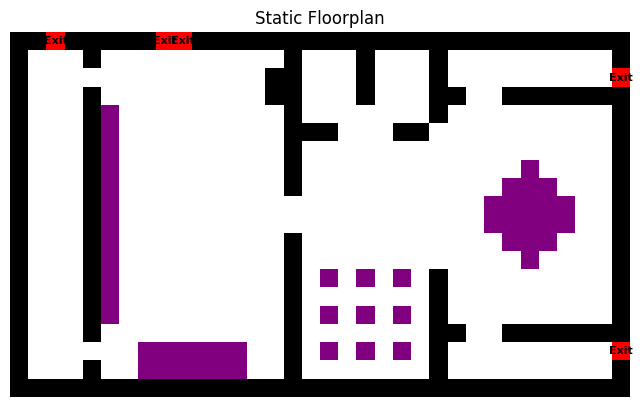

In [21]:
def visualize_static_floorplan(model):
    # Get the grid data from the model (static view, no agents)
    grid_data = model.get_grid()

    # Create a colormap with numerical values for each cell type
    # 0: empty (white), 1: obstacle (black), 2: (agent), 3: exit (red), 4: sign (yellow), 5: low obstacle (purple)
    cmap = ListedColormap(["white", "black", "white", "red", "yellow", "purple"])
    norm = plt.Normalize(vmin=0, vmax=5)

    # Visualize the floorplan
    plt.figure(figsize=(8, 8))
    plt.imshow(grid_data, cmap=cmap, norm=norm)

    for y in range(grid_data.shape[0]):
        for x in range(grid_data.shape[1]):
            if grid_data[y, x] == 3:  # Exit
                plt.text(x, y, 'Exit', color='black', ha='center', va='center', fontsize=8, weight='bold')
            elif grid_data[y, x] == 4:  # Sign
                plt.text(x, y, 'Sign', color='black', ha='center', va='center', fontsize=8, weight='bold')

    plt.title("Static Floorplan")
    plt.axis("off")  # Remove axis for a cleaner look
    plt.show()

# Usage: Assuming the model is already created
visualize_static_floorplan(model)

In [22]:
print("\nModel Data:")
model_data


Model Data:


,Active Agents,Exited Agents,Cumulative Exited Agents,Density,Percentage Exited,Agents per Cell,Agents in Exits,Cumulative exited agents per exit
0,300,0,0,0.652174,0.000000,"{(1, 1): 1, (1, 6): 1, (1, 10): 1, (1, 13): 1,...","{(9, 0): 2, (33, 2): 2}","{(2, 0): 0, (8, 0): 0, (9, 0): 2, (33, 2): 2, ..."
1,296,0,4,0.643478,1.333333,"{(1, 9): 1, (1, 13): 1, (1, 16): 1, (1, 17): 1...","{(2, 0): 3, (8, 0): 4, (33, 2): 2}","{(2, 0): 3, (8, 0): 4, (9, 0): 2, (33, 2): 4, ..."


In [23]:
print("\nAgent Data:")
agent_data.head(40)



Agent Data:


Found Exit  Toxicated
Step AgentID                       
0    1             False       True
     2             False       True
     3             False       True
     4             False       True
     5             False       True
     6             False       True
     7             False       True
     8             False       True
     9             False       True
     10            False       True
     11            False       True
     12            False       True
     13            False       True
     14            False       True
     15            False       True
     16            False       True
     17            False       True
     18            False       True
     19            False       True
     20            False       True
     21            False       True
     22            False       True
     23            False       True
     24            False       True
     25            False       True
     26            False       True
     27            False       True
     28            False       True
     29            False       True
     30            False       True
     31            False       True
     32            False       True
     33            False       True
     34            False       True
     35            False       True
     36            False       True
     37            False       True
     38            False       True
     39            False       True
     40            False       True

In [24]:
# Uncomment the code below to display the 'Agents per Cell' data for each step

# print("Agents per Cell at each step:")
# for step, agents_per_cell in model_data["Agents per Cell"].items():
#    print(f"\nStep {step}:")
#    for cell, count in agents_per_cell.items():
#        print(f"  Cell {cell}: {count} agent(s)")